This code is developed by "Fatemehzahed kachaee" based on "Hamiltonian Neural Networks by
Sam Greydanus, Misko Dzamba, Jason Yosinski"

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import autograd
import pandas as pd
np.random.seed(0)

In [2]:
def grad_Hamiltonian(t,r):
        q, p = r 
        tfq= tf.Variable([q], dtype=tf.double)
        tfp= tf.Variable([p], dtype=tf.double)
        with tf.GradientTape() as g:
            g.watch([tfp,tfq])
            H= tfq**2+ tfp**2
            dHdq,dHdp = g.gradient(H, [tfq,tfp])    # pdot=-dH_dq,qdot=dH_dp
        S = np.concatenate([dHdp, -dHdq], axis=-1)
        return S
        

# trajectory

def trajectory(t,y0):
   
    noise_std=0.1
    sol = integrate.solve_ivp(fun=grad_Hamiltonian,t_span=t,y0=y0,t_eval=np.linspace(0,10,100))
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    q_new += np.random.randn(*q_new.shape)*noise_std
    p_new += np.random.randn(*p_new.shape)*noise_std
    return q_new,p_new,dq,dp


In [3]:
def get_dataset(seed=0, samples=50, test_split=0.2):    # inja 50ta nemune random az file data bardashte be surste zoje moratab p&q va dp&dq neveshte va 20 darsad oona ro dade test ghara dade
    data = {'meta': locals()}
    t=[0,10]
    y0=np.asarray([1.0,0.0])
    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dq, dp= trajectory(t,y0)
        xs.append( np.stack( [q, p]).T )
        dxs.append( np.stack( [dq, dp]).T )
        
    data['q&p'] = np.concatenate(xs)
    data['dq&dp'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['q&p']) * test_split)
    split_data = {}
    for k in ['q&p', 'dq&dp']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [4]:
data = get_dataset()
x_train = tf.constant(data['q&p'], dtype=tf.double)
x_test = tf.constant( data['test_q&p'], dtype=tf.double)
y_train = tf.constant(data['dq&dp'], dtype=tf.double)
y_test = tf.constant(data['test_dq&dp'], dtype=tf.double)

In [5]:
# data = get_dataset()
# x_train = tf.constant(data['q&p'], dtype=tf.float32)
# x_test = tf.constant( data['test_q&p'], dtype=tf.float32)
# y_train = tf.constant(data['dq&dp'])
# y_test = tf.constant(data['test_dq&dp'])

# Baseline model

In [6]:
myModel=keras.models.Sequential()
myModel.add(keras.layers.Flatten(input_shape=[2]))
myModel.add(keras.layers.Dense(100, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(200, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(2))#, activation="sigmoid"))

myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 20,902
Trainable params: 20,902
Non-trainable params: 0
____________________________________________________

In [7]:
myModel.compile(loss=tf.keras.losses.MeanAbsoluteError(),#loss
                optimizer=keras.optimizers.Adam(lr=1e-3),
                metrics=["accuracy"])

trainedModel=myModel.fit(x_train,y_train, epochs=15
                        ,validation_split=(0.2))

Epoch 1/15
25/25 [==============================] - 0s 11ms/step - loss: 0.4877 - accuracy: 0.9100 - val_loss: 0.2029 - val_accuracy: 0.9650
Epoch 2/15
25/25 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9550 - val_loss: 0.1630 - val_accuracy: 0.9650
Epoch 3/15
25/25 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.9613 - val_loss: 0.1620 - val_accuracy: 0.9750
Epoch 4/15
25/25 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.9688 - val_loss: 0.1570 - val_accuracy: 0.9700
Epoch 5/15
25/25 [==============================] - 0s 3ms/step - loss: 0.2040 - accuracy: 0.9638 - val_loss: 0.1554 - val_accuracy: 0.9750
Epoch 6/15
25/25 [==============================] - 0s 3ms/step - loss: 0.1983 - accuracy: 0.9663 - val_loss: 0.1614 - val_accuracy: 0.9650
Epoch 7/15
25/25 [==============================] - 0s 3ms/step - loss: 0.2017 - accuracy: 0.9625 - val_loss: 0.1636 - val_accuracy: 0.9700
Epoch 8/15
25/25 [=

<AxesSubplot:>

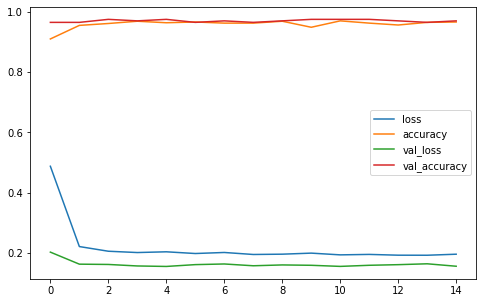

In [8]:
pd.DataFrame(trainedModel.history).plot(figsize=(8, 5))

In [9]:
myModel.evaluate(x_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9722


[0.1549786627292633, 0.9722499847412109]

In [10]:
def pred_pdot_qdot(t,r):
    q,p = r 
    new_init_val= np.array([[q,p]])
    y=myModel.predict(new_init_val)[0]
    return(y[0],y[1])

In [11]:
def Data(t,y0):
    noise_std=0.1
    sol = integrate.solve_ivp(fun=pred_pdot_qdot,t_span=t,y0=y0,t_eval=np.linspace(0,30,300))
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    return q_new,p_new,dq,dp
    return q_new,p_new,dq,dp

In [12]:
t=(0,30)
init_val=np.asarray([1.0,0.0])
pred_p,pred_q,pred_pdot,pred_qdot=Data(t,init_val)

In [13]:
a,b=np.transpose(x_train)
qt,uselesq=np.split(a,[300])
pt,uselesp=np.split(b,[300])

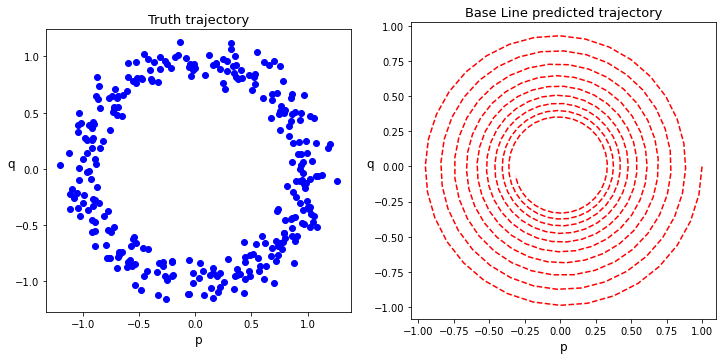

In [14]:
x,y=np.transpose(x_train)
xx,yy=np.transpose(y_train)

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(qt,pt,'bo')
plt.axis('scaled')
plt.title('Truth trajectory', fontsize=13)
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)

plt.subplot(222)
plt.plot(pred_p,pred_q,'r--')
plt.title('Base Line predicted trajectory', fontsize=13)
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)

plt.savefig('trajectory_massSpringBaseline.jpg')

In [15]:
Ht=qt**2+pt**2
Hp=pred_q**2+pred_p**2

In [16]:
meanE=np.mean(Ht)*np.ones(len(qt))
pmeanE=np.mean(Hp)*np.ones(len(pred_p))

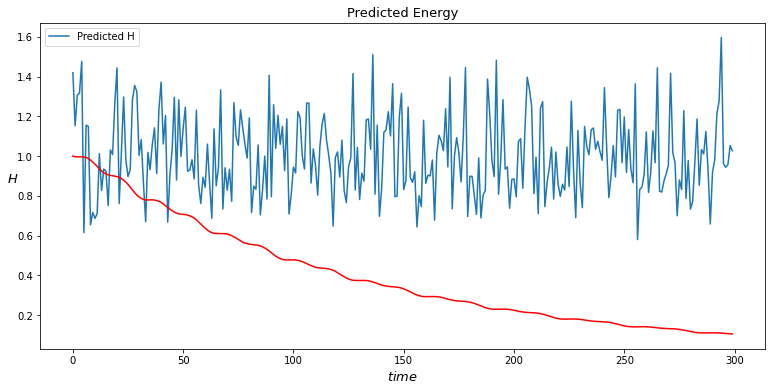

In [28]:
plt.figure(figsize=(13,6))

# plt.subplot(211)
plt.plot(Ht,'-')
# plt.plot(meanE,'y')
# plt.title('Truth Energy', fontsize=13)
# plt.xlabel('time', fontsize=13)
# plt.ylabel('H',rotation=0, fontsize=13)
# plt.legend(['Truth H','mean of Energy'])

# plt.subplot(212)
plt.plot(Hp,'r-')
# plt.plot(pmeanE,'y')
plt.title('Predicted Energy', fontsize=13)
plt.legend(['Predicted H'])
plt.xlabel('$time$', fontsize=13)
plt.ylabel('$H$',rotation=0, fontsize=13)
plt.savefig('hamiltonyPerTime_massSpringBaseline.jpg')

# HNN model

In [18]:
# This part of the code is taken directly from "Hamiltonian Neural Networks Ayush Garg Sammed Shantinath Kagi"
# https://github.com/ayushgarg31/HNN-Neurips2019
class HNN(keras.Model):
    def __init__(self, input_dim=2, hidden_dim=200):
        super(HNN, self).__init__()
        self.d1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.d2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.d3 = tf.keras.layers.Dense(1)
        M = np.eye(input_dim)
        M = np.concatenate((M[input_dim//2:], -M[:input_dim//2]), axis=0)
        self.M = tf.constant(M, dtype='double')

    def call(self, x):
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        return y

    def forward(self, x):
        with tf.GradientTape() as tape:
            y = self.d1(x)
            y = self.d2(y)
            y = self.d3(y)
        y = tape.gradient(y, x)
        y = y @ self.M
        return y

In [19]:
def train_HNN(data, learning_rate = 1e-3, epochs = 200):
    model = HNN(input_dim=x_train.shape[1], hidden_dim=200)
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(epochs):
        with tf.GradientTape() as tape1:
            tape1.watch(model.trainable_variables)
            predictions = model.forward(tf.Variable(tf.stack(x_train)))
            loss = loss_object(tf.Variable(tf.stack(y_train)), predictions)
        gradients = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        #print (i, loss)
    return model

In [20]:
hnn_model = train_HNN(data, epochs=200, learning_rate=1e-3);

In [21]:
def integrate_model_HNN(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = tf.Variable(tf.reshape(np_x, (1,2)), dtype='double')
        dx = model.forward(np_x)
        return dx
    return integrate.solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [22]:
def integrate_models(x0=np.asarray([1, 0]), t_span=None, t_eval=None, noise_std=0.1):
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = integrate.solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    hnn_ivp = integrate_model_HNN(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_ivp['y'].T
    
    return true_x 

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

In [23]:
t_span = [0,30]
y0 = np.array([1.0, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 300), 'rtol': 1e-12}
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)

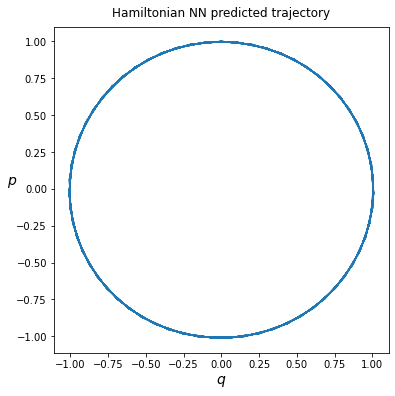

In [24]:
qhnn,phnn=hnn_ivp.y
fig = plt.figure(figsize=(6, 6), facecolor='white')

fig.add_subplot(1, 1, 1, frameon=True)
plt.plot(phnn,qhnn)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN predicted trajectory", pad=10);
plt.savefig('trajectory_massSpringHNN.jpg')

Text(0, 0.5, '$H$')

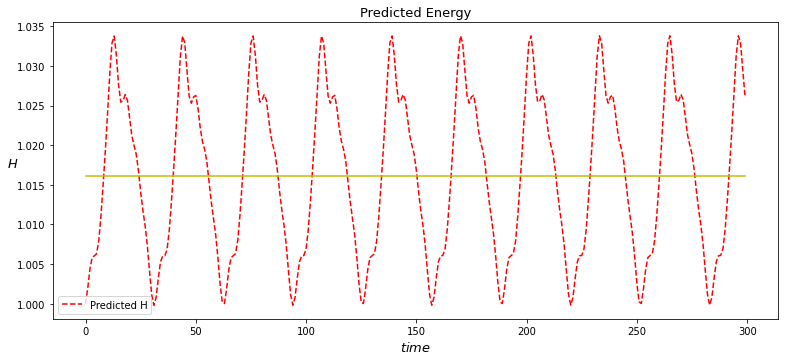

In [25]:
Hphnn=qhnn**2+phnn**2
pmeanEhnn=np.mean(Hphnn)*np.ones(len(phnn))
plt.figure(figsize=(13,12))

plt.subplot(212)
plt.plot(Hphnn,'r--')
plt.plot(pmeanEhnn,'y')
plt.title('Predicted Energy', fontsize=13)
plt.legend(['Predicted H'])
plt.xlabel('$time$', fontsize=13)
plt.ylabel('$H$',rotation=0, fontsize=13)

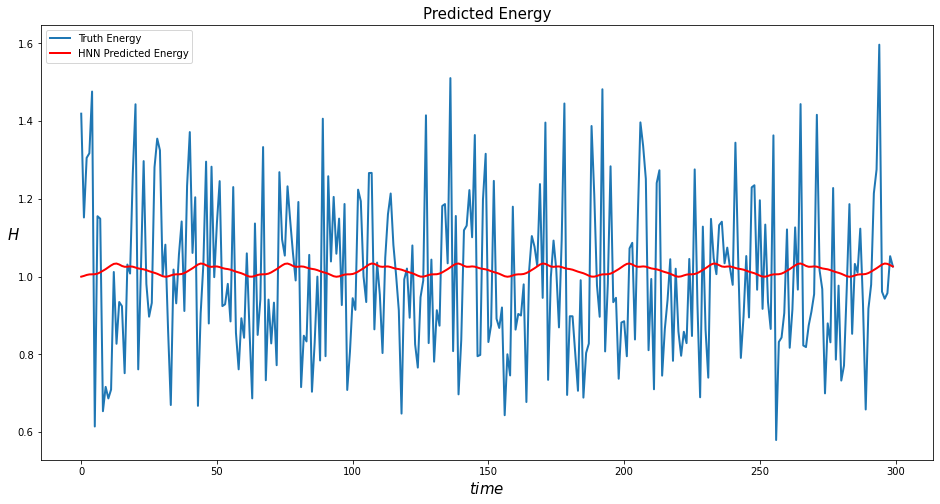

In [27]:
Hphnn=qhnn**2+phnn**2
pmeanEhnn=np.mean(Hphnn)*np.ones(len(phnn))
plt.figure(figsize=(16,8))


plt.plot(Ht,
         '-',
         lw=2,
         label='Truth Energy'
        )
# plt.plot(meanE,
#          '--',
#         )
# plt.plot(pmeanE,'y')


plt.plot(Hphnn,
         'r-',
         lw=2,
         label='HNN Predicted Energy'
        )
# plt.plot(pmeanEhnn,
#          'r--'
#         )

plt.title('Predicted Energy', fontsize=15)


# plt.plot(Hp,
#          'k-',
#          lw=2,
#          label='Baseline Predicted Energy'
#         )

plt.legend(loc='best', ncol=1)
plt.xlabel('$time$', fontsize=15)
plt.ylabel('$H$',rotation=0, fontsize=15)

plt.savefig('hamiltonyPerTime_massSpringHNN.jpg')